In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler

from collections import OrderedDict

from scipy.special import sph_harm
import matplotlib.cm
import cartopy.crs as ccrs

In [2]:
# Visualisation Input

model_path = "Data:Geoid:new_results_1k_zero:zero_1k-inv.npy,Data:Geoid:new_results_1k_zero:zero_1k-geoid.npy,200:160:120:80,ReLU,MSELoss,200,16,0.0001,0.01,MinMax,1k_zero.pth"
training_data_path = "1D_results/"+model_path[:len(model_path)-4] + "_trainingData.txt"

#parameters = model_path.split('/')[1].replace(':','/').split(',')
parameters = model_path.replace(':','/').split(',')

input_PATH = parameters[0]
output_PATH = parameters[1]

output_scaler = parameters[9]
loss_type = parameters[4]
act_function = parameters[3]
accurate_loss_baseline = float(parameters[8])
batch_size = int(parameters[6])

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if output_scaler == "MinMax":
    output_for_Scalar = np.load(output_PATH)
    scaler = MinMaxScaler()
    scaler.fit(output_for_Scalar)
    print("Fit the output range to [0,1] using MinMaxscaler")
    
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = np.load(input_path)
        output_data = np.load(output_path)
        
        if output_scaler == "MinMax":
            output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item
        
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset

geoid_dataset = KMNIST(
    input_PATH,
    output_PATH,
)


# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)

geoid_train_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)
    
print("Dataset Loaded!\n")

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler
Dataset Loaded!



In [4]:
# Geoid Coefficient visualize helper
def mk_image(coeff, phi, theta, latsamples = 100, lonsamples = 100):

    accum = 0.0*sph_harm(0, 0, theta, phi)
    offset = 0
    for l in range(2, 8):
        for m in range(-l, l + 1):
            accum += coeff[offset] * sph_harm(m, l, theta, phi)
            offset += 1

    return np.real(accum)

# Function to fix errors when using pyshtools
def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.len()

setattr(np, "alen", patch_asscalar)


import pyshtools

def mk_image_pyshtools(coeff, phi, theta, latsamples = 100, lonsamples = 100):

    sph = pyshtools.SHCoeffs.from_zeros(lmax = 7, normalization = 'ortho')

    offset = 0
    for l in range(2, 8):
        for m in range(-l, l + 1):
            sph.set_coeffs(coeff[offset], l, m)
            offset += 1

    image = sph.expand(lon = theta.flatten() * 180.0/np.pi,
                       lat = 90.0 - phi.flatten() * 180.0/np.pi)

    return image.reshape(theta.shape)

In [9]:
# Testing Function
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    
    threshold_list = [1e-2,1e-3,1e-4,1e-5]
    threshold_correct_list = [0,0,0,0]
        
    criterion = nn.MSELoss()
    if loss_type == 'L1Loss':
        criterion = nn.L1Loss()
            
    total_loss = 0.0
        
    
    best_worst_error_list = [1000000, 0]
    best_worst_reconstructed_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(torch.float32)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than accurate loss baseline, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                single_loss_reconstructed = criterion(torch.from_numpy(scaler.inverse_transform([outputs[j].detach().numpy()])[0]), 
                                                      torch.from_numpy(scaler.inverse_transform([labels[j].detach().numpy()])[0]))
                
                if single_loss.item() <= accurate_loss_baseline:
                    correct += 1
                    
                for t_index in range(len(threshold_list)):
                    if single_loss.item() <= threshold_list[t_index]:
                        threshold_correct_list[t_index] += 1
                               
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_reconstructed_error_list[1] = single_loss_reconstructed.item()
                    
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_reconstructed_error_list[0] = single_loss_reconstructed.item()
                    
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is {}, and accuracy is {}%".format(total_loss,100*correct//total))
    
    # Calculate accuracy using pre-defined loss threshold
    for i in range(len(threshold_list)):
        print("When the normalised loss threshold is set to {}, accuracy is {}%".format(threshold_list[i],100*threshold_correct_list[i]//total))
    print()

    
    
    # General Best case plot
    print("Best model has a normalized error of ", best_worst_error_list[0])
    print("Best model has a reconstructed error of ", best_worst_reconstructed_error_list[0])
    
    plt.figure(figsize=(12, 6))
        
    plt.subplot(1, 2, 1)
    
    plt.title("Best case input")
    plt.plot(best_worst_input_list[0].detach().numpy())

        
    plt.subplot(1, 2, 2)
    
    plt.title("Best case plot")
    
    if output_scaler == "MinMax":
        plt.plot(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], label='Data Output')
        plt.plot(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], label='Predicted Output')
    else:
        plt.plot(best_worst_output_list[0].detach().numpy(), label='Data Output')
        plt.plot(best_worst_predicted_list[0].detach().numpy(), label='Predicted Output')
        
        
    plt.legend()
    
    plt.show()  
    
    
    # General Worst case plot
    print("Worst model has a normalized error of ", best_worst_error_list[1])
    print("Worst model has a reconstructed error of ", best_worst_reconstructed_error_list[1])
    
    plt.figure(figsize=(12, 6))
        
    plt.subplot(1, 2, 1)
    
    plt.title("Worst case input")
    plt.plot(best_worst_input_list[1].detach().numpy())

    plt.subplot(1, 2, 2)
    
    plt.title("Worst case plot")
    
    if output_scaler == "MinMax":
        plt.plot(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], label='Data Output')
        plt.plot(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], label='Predicted Output')
    else:
        plt.plot(best_worst_output_list[1].detach().numpy(), label='Data Output')
        plt.plot(best_worst_predicted_list[1].detach().numpy(), label='Predicted Output')
        
    plt.legend()

    plt.show()
    
    
    
    
    # Pick a set of coefficients
    phi = np.linspace(0.0, np.pi, 100)
    theta = np.linspace(0.0, 2.0*np.pi, 100)
    theta, phi = np.meshgrid(theta, phi)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    lons = theta * 180.0/np.pi
    lats = 90.0 - phi*180.0/np.pi
    
    
    # Geoid Coefficient visualization for Best case
    best_real_image = mk_image_pyshtools(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], phi, theta)
    best_predicted_image = mk_image_pyshtools(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], phi, theta)
    best_error_image = np.abs(mk_image_pyshtools(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0]-scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], phi, theta))
    
    
    fig = plt.figure(1)
    fig.set_size_inches(16, 8)
        
    ax1 = fig.add_subplot(131, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Real geoid field")
    sc1 = ax1.contourf(lons, lats, best_real_image, 50, transform = ccrs.PlateCarree(), cmap = 'seismic')
    ax1.coastlines()
    fig.colorbar(sc1, ax=ax1, orientation="horizontal", label="values")
    
    ax2 = fig.add_subplot(132, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Geoid field using predicted coefficients")
    sc2 = ax2.contourf(lons, lats, best_predicted_image, 50, transform = ccrs.PlateCarree(), cmap = 'seismic')
    ax2.coastlines()
    fig.colorbar(sc2, ax=ax2, orientation="horizontal", label="values")
    
    ax3 = fig.add_subplot(133, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Error between geoid fields")
    sc3 = ax3.contourf(lons, lats, np.abs(best_error_image), 50, transform = ccrs.PlateCarree(), cmap = 'magma')
    ax3.coastlines()
    fig.colorbar(sc3, ax=ax3, orientation="horizontal", label="values")
    
    plt.show()
    
    
    
    # Geoid Coefficient visualization for Worst case
    worst_real_image = mk_image_pyshtools(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], phi, theta)
    worst_predicted_image = mk_image_pyshtools(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], phi, theta)
    worst_error_image = np.abs(mk_image_pyshtools(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0]-scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], phi, theta))
    
    
    
    fig = plt.figure(1)
    fig.set_size_inches(16, 8)
        
    ax1 = fig.add_subplot(131, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Real geoid field")
    sc1 = ax1.contourf(lons, lats, worst_real_image, 50, transform = ccrs.PlateCarree(), cmap = 'seismic')
    ax1.coastlines()
    fig.colorbar(sc1, ax=ax1, orientation="horizontal", label="values")
    
    ax2 = fig.add_subplot(132, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Geoid field using predicted coefficients")
    sc2 = ax2.contourf(lons, lats, worst_predicted_image, 50, transform = ccrs.PlateCarree(), cmap = 'seismic')
    ax2.coastlines()
    fig.colorbar(sc2, ax=ax2, orientation="horizontal", label="values")
    
    ax3 = fig.add_subplot(133, projection = ccrs.Robinson(central_longitude = 0.0))
    plt.title("Error between geoid fields")
    sc3 = ax3.contourf(lons, lats, np.abs(worst_error_image), 50, transform = ccrs.PlateCarree(), cmap = 'magma')
    ax3.coastlines()
    fig.colorbar(sc3, ax=ax3, orientation="horizontal", label="values")
    
    plt.show()
    
    '''
    best_worst_image_list = [best_real_image, best_predicted_image, worst_real_image, worst_predicted_image]
    best_worst_image_title = ["Real Coefficients (Best)","Predicted Coefficient (Best)","Real Coefficient (Worst)","Predicted Coefficient (Worst)"]
    vmin_image = np.asarray(best_worst_image_list).flatten().min()
    vmax_image = np.asarray(best_worst_image_list).flatten().max()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(16, 8)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(best_worst_image_list[i], origin = 'lower', extent = [0, 360, -90, 90], cmap = 'seismic', vmin = vmin_image, vmax = vmax_image)
        ax.set_title(best_worst_image_title[i])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    
    
    best_worst_error_list = [best_error_image, worst_error_image]
    best_worst_error_title = ["Coefficients error (Best)", "Coefficients error (Worst)"]
    vmin_error = np.asarray(best_worst_error_list).flatten().min()
    vmax_error = np.asarray(best_worst_error_list).flatten().max()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(16, 8)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(best_worst_error_list[i], origin = 'lower', extent = [0, 360, -90, 90], cmap = 'magma', vmin = vmin_error, vmax = vmax_error)
        ax.set_title(best_worst_error_title[i])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    '''
    
    #return 100*correct//total, total_loss

In [10]:
# Initialize Model and Optimizer
hidden_layers_list = [int(x) for x in parameters[2].split('/')]
neurons_list = [len(geoid_dataset.input[0])] + hidden_layers_list + [len(geoid_dataset.output[0])]
layers_od = OrderedDict()
for i in range(len(neurons_list)-1):
    fc_name = 'fc' + str(i+1)
    layers_od[fc_name] = nn.Linear(neurons_list[i], neurons_list[i+1])
        
    if act_function == "ReLU" and i != len(neurons_list)-2:
        act_name = 'relu' + str(i+1)
        layers_od[act_name] = nn.ReLU()
            
model = nn.Sequential(layers_od).to(device)
print(model)
print()

Sequential(
  (fc1): Linear(in_features=257, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=160, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=160, out_features=120, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=120, out_features=80, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=80, out_features=60, bias=True)
)



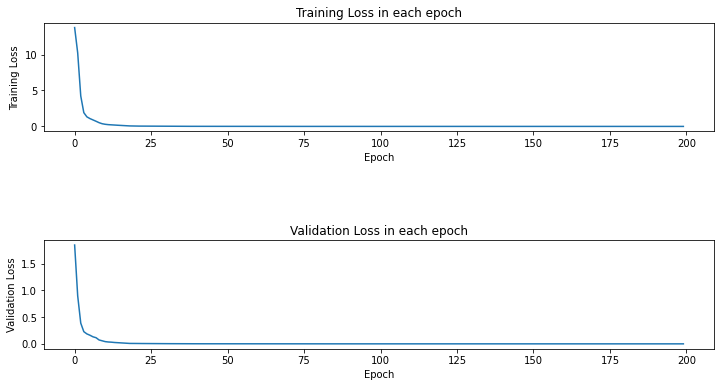

In [11]:
file1 = open(training_data_path, 'r')
Lines = file1.readlines()

training_data_list = []
for line in Lines:
    training_data_list.append([float(x) for x in line.strip().split('/')])
    
# Plot the Training loss and validation loss during training
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 1, 1)
plt.plot(training_data_list[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss in each epoch')

plt.subplot(2, 1, 2)
plt.plot(training_data_list[1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss in each epoch')
    
plt.subplots_adjust(hspace=1)
    
plt.show()

In [12]:
model.load_state_dict(torch.load("1D_results/"+model_path))
#test(model, geoid_train_loader, device)

<All keys matched successfully>

Total loss for the model is 0.0006055624549765284, and accuracy is 100%
When the normalised loss threshold is set to 0.01, accuracy is 100%
When the normalised loss threshold is set to 0.001, accuracy is 99%
When the normalised loss threshold is set to 0.0001, accuracy is 73%
When the normalised loss threshold is set to 1e-05, accuracy is 39%

Best model has a normalized error of  8.87803404791261e-07
Best model has a reconstructed error of  0.0005746000823757588


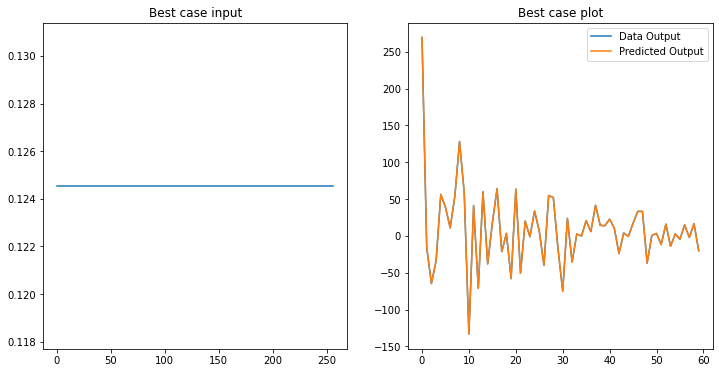

Worst model has a normalized error of  0.0010622848657085785
Worst model has a reconstructed error of  2.647607141963807


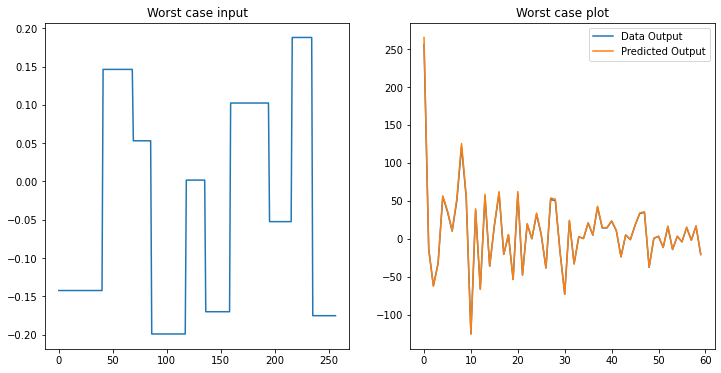

/Users/xuke/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


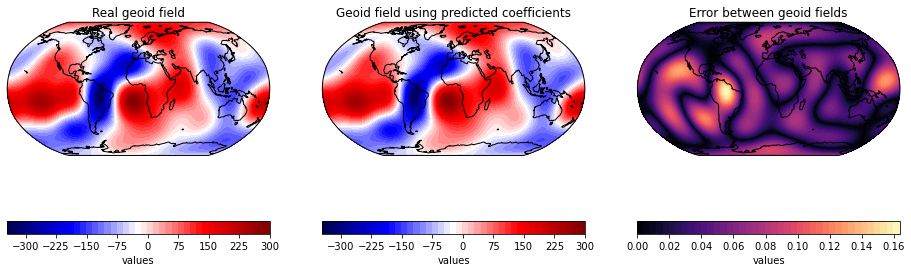

/Users/xuke/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


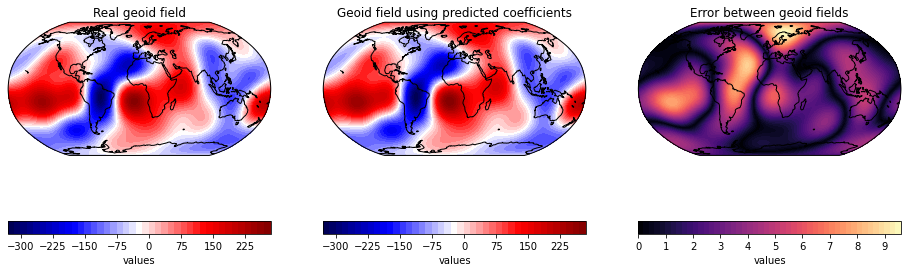

In [13]:
test(model, geoid_test_loader, device)